In [68]:
import pandas as pd
pd.options.plotting.backend = "plotly"

### Load the sampled version of the dataset (5 000 songs)

In [76]:
df = pd.read_csv("./data/song_lyrics_sampled.csv")
print('Data rows number: ', len(df))
df.head()

Data rows number:  5000


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Etap,rap,Der Plot,2014,124,{},"[Part I - Conny:]\nGuten Morgen fremdes Bett, ...",383522,de,de,de
1,Toothpick,pop,Biting Elbows,2012,8873,{},Some folks got the patience of the angels\nNot...,1166787,en,en,en
2,6 Feet Under,pop,Ana Johnsson,2004,60,{},You just left me 6 feet under ground I'm burni...,803057,en,en,en
3,Ir Al Baile,pop,Onda Vaga,2015,731,{},Cuando a los doce llevé la bandera en el hombr...,905848,es,es,es
4,Prudenza mai,pop,Ivan Graziani,1989,35,{},"Prudenza mai, mai...\nMai neanche da bambino\n...",1304379,it,it,it


### Drop useless columns and keep only english songs

In [77]:
# consider only english songs
df = df[df.language == 'en']
# drop rows containing NaN values
df = df.dropna()
# drop useless columns
df = df.drop(['language_cld3', 'language_ft','language','features','views'], axis=1)
print('Data rows number: ', len(df))
df.head()

Data rows number:  3919


,title,tag,artist,year,lyrics,id
1,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787
2,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057
5,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438
6,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823
7,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619


### Dataset preprocessing

In [79]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

stop_words = stopwords.words('english')
new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
stop_words.extend(new_stop_words)


def preprocess_text(text):
    # remove \n
    text = text.replace('\n', ' ')
    # remove punctuation
    text = re.sub(r'[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub(r'\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub(r'\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    # convert all words in lower case
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    # remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    #remove tokens with lenght < 3
    final_tokens = [token for token in lemmatized_tokens if len(token) > 2 and not token.isnumeric()]

    return ' '.join(final_tokens)

cleaned_text = df["lyrics"].apply(preprocess_text)
df["lyrics_proc"] = cleaned_text
df.head()

,title,tag,artist,year,lyrics,id,lyrics_proc
1,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...
2,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...
5,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room lupus house enter lupus histrio lictors t...
6,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...
7,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,'ll never say never cause love head heel love ...


### Analysis

#### Genre

In [80]:
#plot genres
fig_genre = pd.DataFrame(df.tag.value_counts()).plot.bar(template='ggplot2')#title parameters
title_param = dict(text='<b>Count of Genre</b><br></b>', 
                        font=dict(size=20))#update layout
fig_genre.update_layout(title=title_param,
                  width=700,
                  height=400,        
                  xaxis = dict(title='Genre'),
                  yaxis = dict(title='Count'))#change the colour
fig_genre.update_traces(marker_color='rgb(148, 103, 189)')#show plot
fig_genre.show()

#### Lyrics length

In [82]:
#get lyric frequencies for each song
df['lyrics_num_tks'] = df['lyrics_proc'].map(lambda x: len(x.split()))
#empty list
lyric_count_df = []
#loop through each unique genre
for i in df.tag.unique():
    
    #get subset of genres appended to list
    lyric_count_df.append(pd.DataFrame(df[df.tag == i]['lyrics_num_tks']))
    
#concat all DataFrames where each column is a genre
word_counts = pd.concat([i for i in lyric_count_df],axis=1)
#update columns
word_counts.columns = df.tag.unique()
#plot lyric count distributon for each genre
fig_dist = word_counts.plot.box(template='ggplot2')

#title parameters
title_param = dict(text='<b>Distribution of lyrics length by genre</b><br></b>', 
                        font=dict(size=20))

#margin parameters
margin_param=dict(l=25,r=25,b=50,t=50,pad=0)

#update layout
fig_dist.update_layout(title=title_param,
                       margin=margin_param,
                       width=700,
                       height=400,  
                       xaxis = dict(title_text='Genre',title_font = dict(size=10),tickfont=dict(size=10)),
                       yaxis = dict(title_text='Song lyrics length (n tokens)',title_font = dict(size=10),tickfont=dict(size=10)))

#update colours
fig_dist.update_traces(marker_color='rgb(148, 103, 189)')

#show plot
fig_dist.show()

#### POS tagging

In [84]:
import spacy

#load spacy model
nlp = spacy.load('en_core_web_sm')

def pos(tks,pos):
    
    """Returns any token that qualifies as a specific part of speech"""
    #string = ' '.join(tks)
    doc = nlp(tks) #fit model
    
    return ' '.join(list(set([i.text for i in doc if i.pos_ == pos]))) #return any tokens that qualify

#get nouns
df['nouns'] = df.lyrics_proc.map(lambda x: pos(x,'NOUN'))

#get verbs
df['verbs'] = df.lyrics_proc.map(lambda x: pos(x,'VERB'))

#get adjectives
df['adjectives'] = df.lyrics_proc.map(lambda x: pos(x,'ADJ'))

#get adverbs
df['adverbs'] = df.lyrics_proc.map(lambda x: pos(x,'ADV'))

In [85]:
df.iloc[:5,-4:]

,nouns,verbs,adjectives,adverbs
1,gon light smoking yearns angel folk rate idiot...,stole ' done look drove moving felt say leave ...,low flawed great strong bad free red lower moral,softly back well halfway away still maybe better
2,light sign burning leave wrong ground eye life...,drown burning done leave left gone buried brok...,long scar open,far still apart around
5,experiment project purchase poison letter dog ...,shut worship look say directed enter going tak...,sure much cunning pothecary apothecary private...,half yet here forward
6,gon cat skid roof dog goin wind mountain mile ...,blow gone drain bring left know lost told said...,strange cool right backhe locomotive steal hig...,maybe back better
7,head hat sky thought heel love thing goodbye,die missed said kiss walked cause kissing say,sweet,away never


#### Common words

(-0.5, 699.5, 399.5, -0.5)

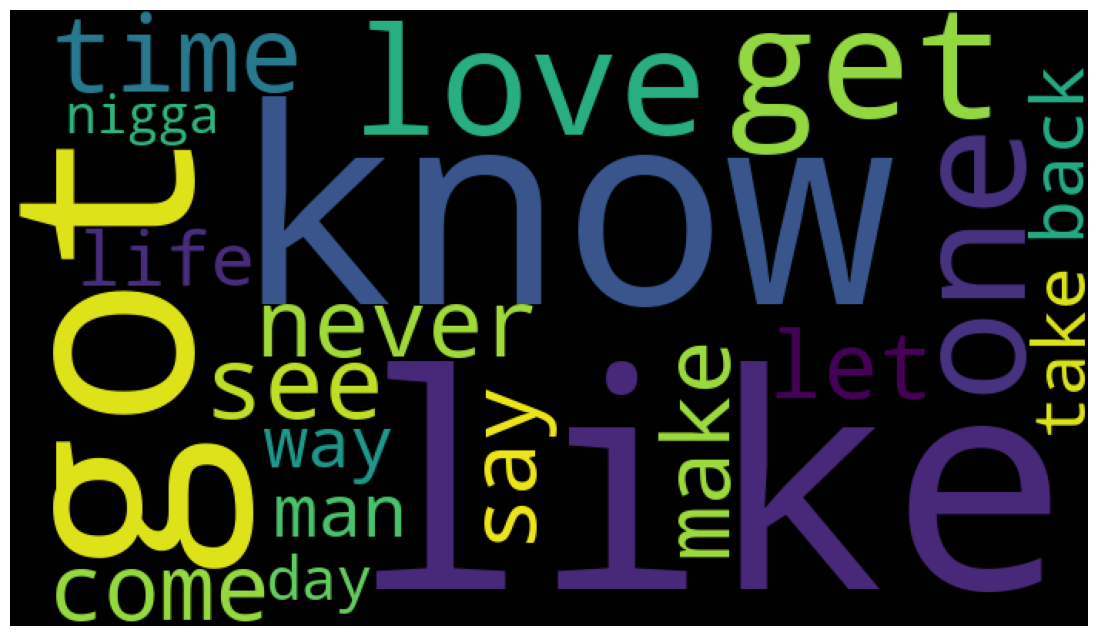

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt   

def mostcommonTokens(data,token=1):
    
    """Returns a DataFrame of the most common n (arg)tokens in a string. Excludes stop words. Additional
    stop words can be added"""
    
    stop_words = stopwords.words('english')
    new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']
    stop_words.extend(new_stop_words)

    #instantiate count vectorizer and specify tokens
    vect = CountVectorizer(stop_words=stop_words, ngram_range= (token,token))

    #fit vectorizer
    X = vect.fit_transform(data)
    
    #get word counts as DataFrame
    word_counts = pd.DataFrame(np.asarray(X.sum(axis=0))[0],vect.get_feature_names_out(),columns=['count'])
    
    #sort by count
    word_counts = word_counts.sort_values(by='count', ascending=False)

    return word_counts #return DataFrame

top_tks = mostcommonTokens(df.lyrics_proc,token=1).head(20)
wordcloud = WordCloud(background_color='black', width = 700, height = 400,collocations=False,random_state=100,stopwords=stopwords.words('english')).generate_from_frequencies(top_tks['count'].to_dict())
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

#### Common words tagged as name by genre

In [86]:
import plotly.express as px

def genreMap(df,pos,n=100):
    
    """Visualisation function. Returns a treemap of the most common n tokens that qualify as a part of speech"""
    
    #list to populate subset DataFrame's
    all_df = []

    #loop through unique genres
    for i in df.tag.unique():

        #get most common tokens for part of speech
        temp_df = mostcommonTokens(df[df['tag'] == i][pos]).head(n)
        
        #add column for current genre
        temp_df['tag'] = i

        #append DataFrame to list
        all_df.append(temp_df)

    #concatenate all DataFrame's
    all_df = pd.concat([i for i in all_df])

    #reset index
    all_df.reset_index(drop=False,inplace=True)

    #column labels
    all_df.columns = ['word','count','tag']

    # in order to have a single root node add 'all genres'
    all_df["all genres"] = "all genres" 

    #create plotly treemap figure
    fig = px.treemap(all_df, path=['all genres', 'tag', 'word'], values='count',)
    
    #title parameters
    title_param = dict(text='<b>Most Common Nouns, by genre</b><br>spaCy used for classifying PoS</b>', 
                        font=dict(size=20))
    
    #update layout
    fig.update_layout(title=title_param,
                    font= dict(family='Helvetica',size=10),
                    width=900,
                    height=900,
                    autosize=False,
                    margin=dict(l=40,r=40,b=85,t=100,pad=0,))
        
    #show plot
    fig.show()
    
    return fig

fig_nouns = genreMap(df,'nouns')